## ELEC-4800 (Special Topics - Machine Learning)
## Course Project
## Group: William Naslund, Charles Bollig, Jackson Osborn

For our course project we analyze a Residential Energy Consumption Survey (RECS), taken in 2009. We want to determine which features have the most influence on the energy usage of a home. There are 841 total features in our chosen dataset. We are going to find the 10 most influential features that contribute to total electricity usage in homes given this dataset.

In [1]:
from pandas import read_csv
import sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_regression, chi2, mutual_info_classif, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


## Load the Data
The dataset we are using is available at [https://www.eia.gov/consumption/residential/data/2009/](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata).
Under the "microdata" tab we need the dataset as a CSV.
We also load the layout file which describes the features to only keep the numeric columns.

In [2]:
# layout is the layout data
layout = read_csv('data/public_layout.csv')

# numericColumns
numericColumns = layout[layout['Variable Type'] == 'Numeric']['Variable Name']

In [3]:
# dataPath is the path to the CSV file.
dataPath = 'data/recs2009_public.csv'

# fullData is the pandas Dataframe instance containing our data.
fullData = read_csv(dataPath, usecols=numericColumns)

print('Mean Electricity Usage: %d kWh' % fullData.KWH.mean())
print('Median Electricity Usage: %d kWh' % fullData.KWH.median())

Mean Electricity Usage: 11288 kWh
Median Electricity Usage: 9623 kWh


There are a few rows that contain invalid or non-finite numbers, we are ignoring those since there are very few of them.

In [4]:
# Remove non-finite rows
nonFiniteRows = np.where(np.isfinite(fullData.as_matrix()) == False)[0]
fullData = fullData.drop(fullData.index[nonFiniteRows])

np.isfinite(fullData.as_matrix()).all()

True

In [5]:
# Add classes based on every 1000 kWh of electrical energy consumption
kwhClass = np.round(fullData.KWH / 10000)

# Create labels for each bucket of 1000 kWh using a LabelEncoder
classEncoder = LabelEncoder()
classEncoder.fit(kwhClass)
#y = classEncoder.transform(kwhClass)
y = binarize([fullData.KWH], threshold=fullData.KWH.median())[0]

And we want to predict the electrical energy usage in kWh so we extract and remove that column from the data.
Additionally, we remove any total energy consumption values since we want to predict electrical energy consumption before it has actually been consumed (so the totals are not yet known).

In [6]:
del fullData['KWH']
del fullData['NWEIGHT']
for feature in layout['Variable Name'][840:919]:
    del fullData[feature]

In [7]:
fullData[fullData < 0] = 0

In [8]:
# Split into training and testing set
trainData, testData, yTrain, yTest = train_test_split(fullData, y, train_size=0.2)

## Selecting the most Influential Features
Since we are exploring the electricity usage we want to select the features that are most influential to the total electricity usage.

In [9]:
# To begin with here is the shape of the data
print("%d Samples" % trainData.shape[0])
print("%d Features" % trainData.shape[1])

2416 Samples
841 Features


In [10]:
# kCount is the number of features to select.
kCount = 10

selector = SelectKBest(mutual_info_classif, k=kCount)
selector.fit(trainData, yTrain)

SelectKBest(k=10, score_func=<function mutual_info_classif at 0x109227048>)

In [11]:
choiceIndexes = selector.scores_.argsort()[-kCount:][::-1] # the [::-1] reverses the order (to get the high score first)
choiceColumns = trainData.columns[choiceIndexes]
for i in range(0, len(choiceColumns)):
    print('%s: Score = %.4f' % (choiceColumns[i], selector.scores_[choiceIndexes[i]]))

REPORTABLE_DOMAIN: Score = 0.1022
TEMPHOMEAC: Score = 0.0915
ACROOMS: Score = 0.0905
DIVISION: Score = 0.0884
TOTROOMS: Score = 0.0841
TOTSQFT: Score = 0.0815
TOTHSQFT: Score = 0.0801
USECENAC: Score = 0.0790
TOTSQFT_EN: Score = 0.0784
TOTCSQFT: Score = 0.0783


## Features that influence energy usage the most in a home.
The output above shows the 10 most influential features in our dataset that contribute to total energy usage in homes. It can be observed that some features are dependent on each other, such as the number of bedrooms and heating/cooling usages. It makes sense that a larger home with more bedrooms uses more energy to cool or heat the space. Also it can be observed that AC contributes more usage than heating a home.

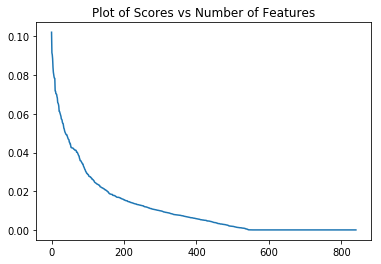

In [12]:
infoScores = selector.scores_[selector.scores_.argsort()[::-1]]

plt.plot(infoScores)
plt.title('Plot of Scores vs Number of Features')

## Building Classifiers
We want to compare the accuracy of a classifier trained with different numbers of features.

In [13]:
selectorIndexes = selector.scores_.argsort()[::-1]

classifiers = {}
for i in range(50,len(trainData.columns),25):
    print('Building Models for %d Features' % i)

    # select the most relevant i features
    choiceData = trainData[selectorIndexes[0:i]]
    choiceIndexes = selector.scores_.argsort()[-i:][::-1] # the [::-1] reverses the order (to get the high score first)
    choiceColumns = trainData.columns[choiceIndexes]
    #for j in range(0, len(choiceColumns)):
    #    print('%i %s: Score = %.4f' % (j,choiceColumns[j], selector.scores_[choiceIndexes[j]]))
    #print(i , "\n")
    
    # train the classifier
    nb = MultinomialNB()
    nb.fit(choiceData, yTrain)
    
    tree = DecisionTreeClassifier()
    tree.fit(choiceData, yTrain)
    
    kn = KNeighborsClassifier()
    kn.fit(choiceData, yTrain)
    
    svm = SVC()
    svm.fit(choiceData, yTrain)
    
    classifiers[i] = {
        "nb": nb,
        "tree": tree,
        "kn": kn,
        "svm": svm,
        "testData": testData[selectorIndexes[0:i]]
    }
    

Building Models for 50 Features
Building Models for 75 Features
Building Models for 100 Features
Building Models for 125 Features
Building Models for 150 Features
Building Models for 175 Features
Building Models for 200 Features
Building Models for 225 Features
Building Models for 250 Features
Building Models for 275 Features
Building Models for 300 Features
Building Models for 325 Features
Building Models for 350 Features
Building Models for 375 Features
Building Models for 400 Features
Building Models for 425 Features
Building Models for 450 Features
Building Models for 475 Features
Building Models for 500 Features
Building Models for 525 Features
Building Models for 550 Features
Building Models for 575 Features
Building Models for 600 Features
Building Models for 625 Features
Building Models for 650 Features
Building Models for 675 Features
Building Models for 700 Features
Building Models for 725 Features
Building Models for 750 Features
Building Models for 775 Features
Building Mod

In [14]:
scores = {
    'nb': [],
    'tree': [],
    'kn': [],
    'svm': []
}
featureCounts = []
for featureCount, clf in classifiers.items():
    print('Scoring with %d features' % featureCount)
    scores['nb'].append(clf['nb'].score(clf['testData'], yTest)*100)
    scores['tree'].append(clf['tree'].score(clf['testData'], yTest)*100)
    scores['kn'].append(clf['kn'].score(clf['testData'], yTest)*100)
    scores['svm'].append(clf['svm'].score(clf['testData'], yTest)*100)
    featureCounts.append(featureCount)

Scoring with 50 features
Scoring with 75 features
Scoring with 100 features
Scoring with 125 features
Scoring with 150 features
Scoring with 175 features
Scoring with 200 features
Scoring with 225 features
Scoring with 250 features
Scoring with 275 features
Scoring with 300 features
Scoring with 325 features
Scoring with 350 features
Scoring with 375 features
Scoring with 400 features
Scoring with 425 features
Scoring with 450 features
Scoring with 475 features
Scoring with 500 features
Scoring with 525 features
Scoring with 550 features
Scoring with 575 features
Scoring with 600 features
Scoring with 625 features
Scoring with 650 features
Scoring with 675 features
Scoring with 700 features
Scoring with 725 features
Scoring with 750 features
Scoring with 775 features
Scoring with 800 features
Scoring with 825 features


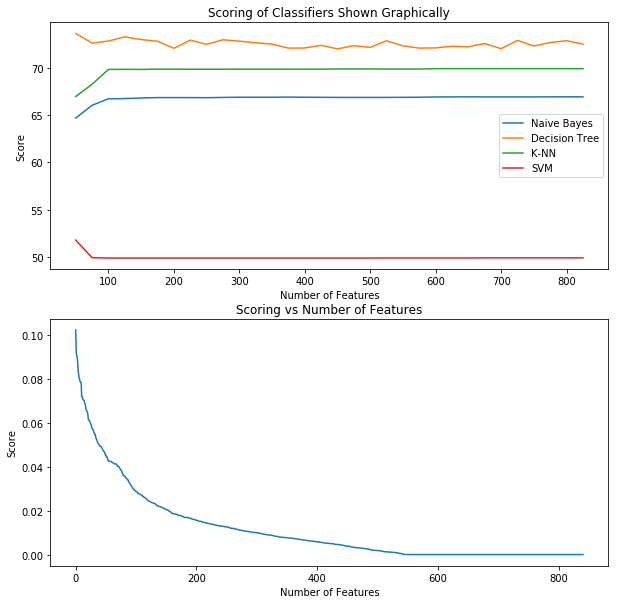

In [16]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(featureCounts, scores['nb'])
plt.plot(featureCounts, scores['tree'])
plt.plot(featureCounts, scores['kn'])
plt.plot(featureCounts, scores['svm'])
plt.legend(['Naive Bayes', 'Decision Tree', 'K-NN', 'SVM'])
plt.title('Scoring of Classifiers Shown Graphically')
plt.ylabel('Score')
plt.xlabel('Number of Features')

plt.subplot(2, 1, 2)
plt.plot(infoScores)
plt.title('Scoring vs Number of Features')
plt.ylabel('Score')
plt.xlabel('Number of Features')

### Conclusion
Our analysis was able to choose which classifier to use based on the score produced. The highest scoring (most accuarate) classifier is the Decision Tree Classifier based on the first of two graph above. There was a number of features that had little to no effect on determining the total energy usage in a home. The 10 features that were the most influential had contributed to the total electricity usage the most, such as AC/heating or the size of the home. Analysis of this data could help a homeowner determine which appliances and features of a home are contributing most to the overall usage. For future application this could help with cutting down the energy bill by targeting unnecessary usage and inefficient parts of a home. This would require a survey that is specific for a single home and a similar analysis. This type of analysis could help with an energy audit and creating more efficient living spaces. Combined with smart homes that could regulate AC/heating when a person is not home.